# Random Forest Model applied to GPS degradation analysis
Linda Capito, 2022

Let us start by loading the GPS dataset of interest:

In [91]:
import pandas as pd

df = pd.read_csv('training/2015-08-12-15-04-18/gps.csv')

pose_timestamps = df['timestamp'].tolist()
origin_timestamp = pose_timestamps[0]

gps_lat = df['latitude']
gps_lon = df['longitude']
gps_north = df['northing']
gps_east = df['easting']
model_df = df

series = model_df.iloc[0:10].copy()

# How to resample the dataframe according to the GPS timestamp
series['timestamp'] = pd.to_datetime(series['timestamp'], unit = 'us')
initial_timestamp = series['timestamp']
print(f'Initial timestamp is {initial_timestamp[0]}')

series.set_index('timestamp', inplace = True)
series.resample('200ms', origin = 'start').interpolate(method='linear')

print(len(series))

Initial timestamp is 2015-08-12 14:04:22.802747
10


Let's explore the incidence of the number of satellites:

In [92]:
print(df['num_satellites'].value_counts()) 

7     2874
6     2637
5     2259
4     1501
8     1374
3      382
9      305
10      61
2       57
1        6
Name: num_satellites, dtype: int64


In [93]:
df1 = pd.read_csv('training/2015-08-12-15-04-18/ins.csv')

ins_lat = df1['latitude']
ins_lon = df1['longitude']
ins_north = df1['northing']
ins_east = df1['easting']

In [97]:
df2 = pd.read_csv('training/2015-08-12-15-04-18/rtk.csv')

rtk_lat = df2['latitude']
rtk_lon = df2['longitude']
rtk_north = df2['northing']
rtk_east = df2['easting']

# print(pd.to_datetime(df2['timestamp'], unit = 'us'))


Original len is 11456


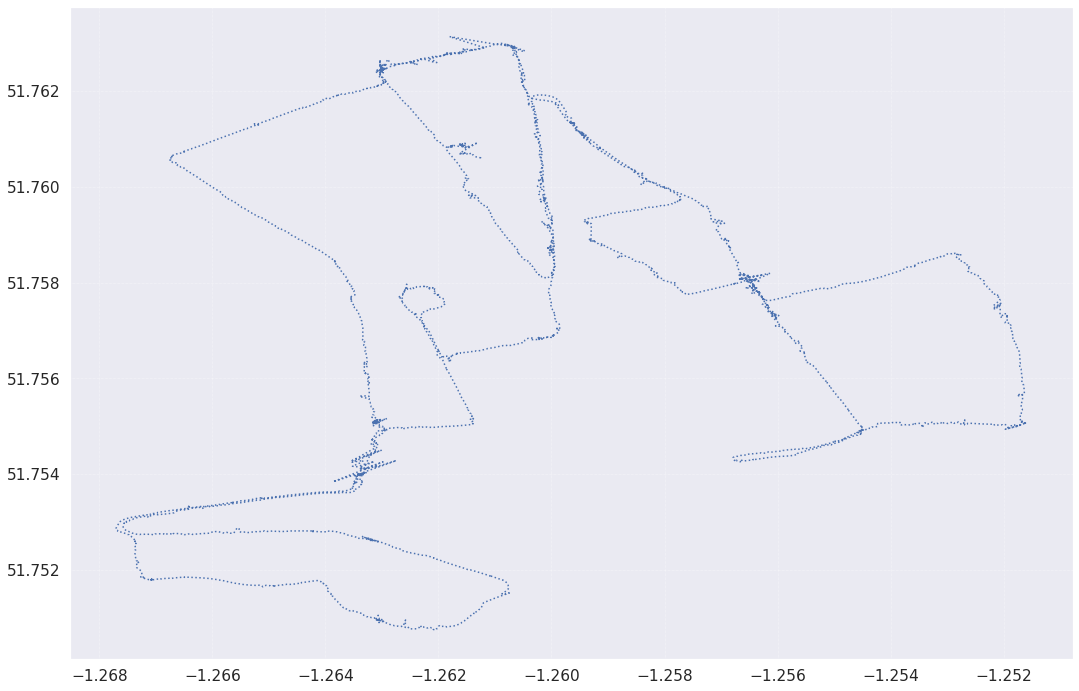

In [98]:
import matplotlib.pyplot as plt

df = pd.read_csv('training/2015-08-12-15-04-18/gps.csv')
print(f'Original len is {len(df)}')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'us')
initial_timestamp = df['timestamp']
df.set_index('timestamp', inplace = True)

# Resample and interpolate data for synchronization
upsample = df.resample('200ms', origin = 'start')
gps = upsample.ffill()

figure = plt.gcf()
figure.set_size_inches(16,12)

# Plot GPS synchronized data
plt.plot(gps['longitude'],gps['latitude'],'b:')
plt.grid(linestyle=':',linewidth=0.5)

Original len is 114561


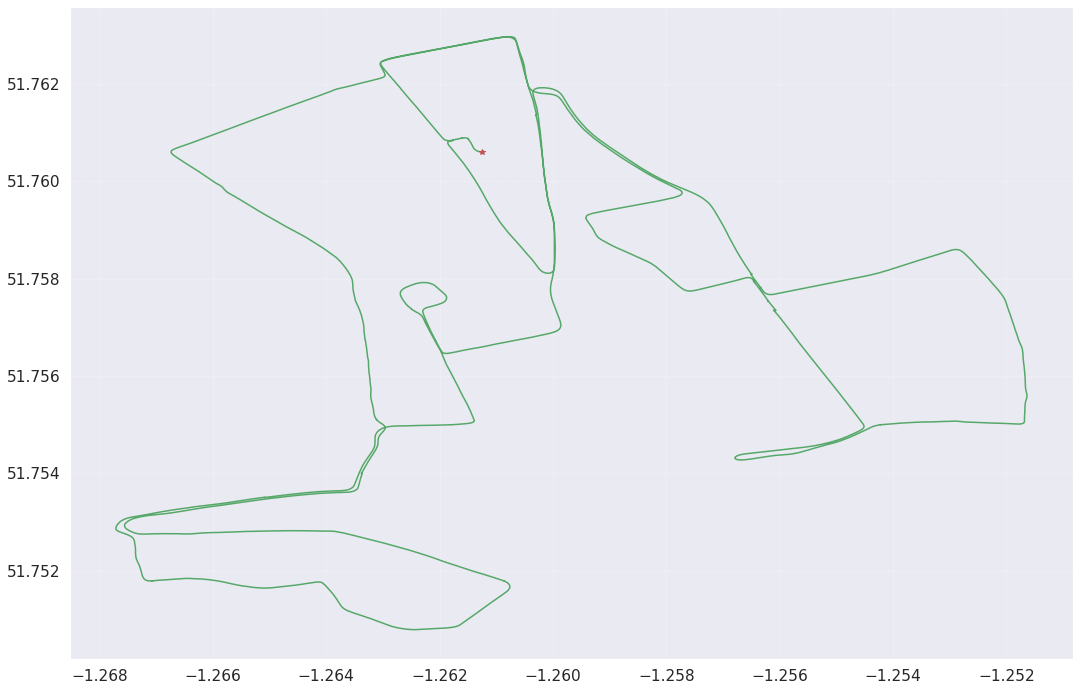

In [99]:
import matplotlib.pyplot as plt

df1 = pd.read_csv('training/2015-08-12-15-04-18/ins.csv')
print(f'Original len is {len(df1)}')
df1['timestamp'] = pd.to_datetime(df1['timestamp'], unit = 'us')
initial_timestamp = df1['timestamp']
df1.set_index('timestamp', inplace = True)
ins_old = df1.resample('200ms', origin = 'start').ffill()

ins = ins_old.iloc[:-1].copy()

figure = plt.gcf()
figure.set_size_inches(16,12)
plt.plot(ins['longitude'],ins['latitude'],'g')
plt.plot(ins['longitude'][0],ins['latitude'][0],'r*')
plt.grid(linestyle=':',linewidth=0.5)


Original len is 22911
2015-08-12 14:42:33.828875


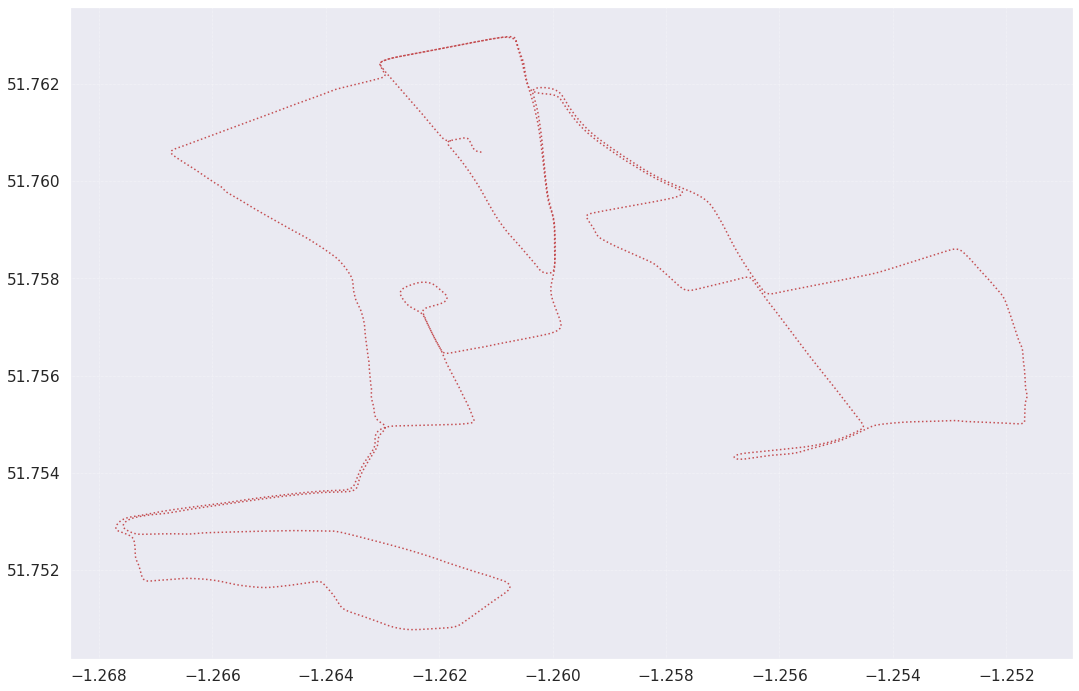

In [100]:
import matplotlib.pyplot as plt

df2 = pd.read_csv('training/2015-08-12-15-04-18/rtk.csv')
print(f'Original len is {len(df2)}')
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit = 'us')
initial_timestamp = df2['timestamp']
print(initial_timestamp[22910])
df2.set_index('timestamp', inplace = True)
rtk = df2.resample('200ms', origin = 'start').ffill()

figure = plt.gcf()
figure.set_size_inches(16,12)
plt.plot(rtk['longitude'],rtk['latitude'],'r:')
plt.grid(linestyle=':',linewidth=0.5)


In [101]:
# Remove timestamps to transform pandas dataframe to array
gps_noindex = gps.copy()
ins_noindex = ins.copy()
rtk_noindex = rtk.copy()

gps_noindex = gps_noindex.rename(columns={'num_satellites':'num_sat', 'latitude':'lat_gps', 'longitude':'lon_gps', 'altitude':'alt_gps', 'latitude_sigma':'lat_sigma', 'longitude_sigma':'lon_sigma', 
       'altitude_sigma':'alt_sigma', 'northing':'north_gps', 'easting':'east_gps', 'down':'down_gps'})
ins_noindex = ins_noindex.rename(columns={'velocity_north':'vel_north_ins', 'velocity_east':'vel_east_ins', 'velocity_down':'vel_down_ins', 'roll':'roll_ins', 'pitch':'pitch_ins',
       'yaw':'yaw_ins'})
rtk_noindex = rtk_noindex.rename(columns={'latitude':'lat_rtk', 'longitude':'lon_rtk', 'altitude':'alt_rtk', 'northing':'north_rtk', 'easting':'east_rtk', 'down':'down_rtk'})       

gps_noindex = gps_noindex.reset_index(drop=True)
ins_noindex = ins_noindex.reset_index(drop=True)
rtk_noindex = rtk_noindex.reset_index(drop=True)


data = [gps_noindex.iloc[:,0:10], ins_noindex.iloc[:, 8:14], rtk_noindex.iloc[:,:6]]

df3 = pd.concat(data, axis = 1)
df3.columns

##### Errors in GPS using northing/easting
df3['northing_error'] = np.abs(df3['north_gps']-df3['north_rtk'])
df3['easting_error'] = np.abs(df3['east_gps']-df3['east_rtk'])
df3['horizontal_error'] = np.sqrt(df3['northing_error']**2+df3['easting_error']**2)

df3['labels_cm'] = np.where(df3['horizontal_error']>10, True, False)

##### Errors in GPS using latitude/longitude
df3['lat_error'] = np.abs(df3['lat_gps']-df3['lat_rtk'])
df3['lon_error'] = np.abs(df3['lon_gps']-df3['lon_rtk'])
df3['deg_error'] = np.sqrt(df3['lat_error']**2+df3['lon_error']**2)

df3['labels_deg'] = np.where(df3['deg_error']>0.0001, True, False)

df3.head()


,num_sat,lat_gps,lon_gps,alt_gps,lat_sigma,lon_sigma,alt_sigma,north_gps,east_gps,down_gps,...,east_rtk,down_rtk,northing_error,easting_error,horizontal_error,labels_cm,lat_error,lon_error,deg_error,labels_deg
0,9,51.760608,-1.261255,68.932093,2.098110,1.597030,5.599122,5.735843e+06,619997.177193,-68.932093,...,619997.103467,-111.009598,1.400986,0.073726,1.402925,False,0.000013,0.000001,0.000013,False
1,9,51.760608,-1.261255,68.927470,2.097983,1.597024,5.599248,5.735843e+06,619997.176174,-68.927470,...,619997.103004,-111.012161,1.391281,0.073170,1.393204,False,0.000013,0.000001,0.000013,False
2,9,51.760608,-1.261255,68.921052,2.098029,1.597101,5.599438,5.735843e+06,619997.185102,-68.921052,...,619997.100627,-111.025429,1.389240,0.084475,1.391806,False,0.000013,0.000001,0.000013,False
3,9,51.760608,-1.261255,68.921958,2.097997,1.597131,5.599644,5.735843e+06,619997.183469,-68.921958,...,619997.101363,-111.021690,1.389680,0.082106,1.392104,False,0.000013,0.000001,0.000013,False
4,9,51.760608,-1.261255,68.927044,2.097923,1.597114,5.599744,5.735843e+06,619997.187288,-68.927044,...,619997.102373,-111.016144,1.399662,0.084915,1.402235,False,0.000013,0.000001,0.000013,False


Find out the number of datapoints in the GPS dataset that present error greater than {0,1,2,..,19} meters.

With error = 0 the number of occurrences is 11456
With error = 1 the number of occurrences is 8768
With error = 2 the number of occurrences is 5389
With error = 3 the number of occurrences is 3349
With error = 4 the number of occurrences is 2331
With error = 5 the number of occurrences is 1786
With error = 6 the number of occurrences is 1430
With error = 7 the number of occurrences is 1159
With error = 8 the number of occurrences is 857
With error = 9 the number of occurrences is 657
With error = 10 the number of occurrences is 523
With error = 11 the number of occurrences is 452
With error = 12 the number of occurrences is 392
With error = 13 the number of occurrences is 344
With error = 14 the number of occurrences is 308
With error = 15 the number of occurrences is 261
With error = 16 the number of occurrences is 233
With error = 17 the number of occurrences is 209
With error = 18 the number of occurrences is 194
With error = 19 the number of occurrences is 170


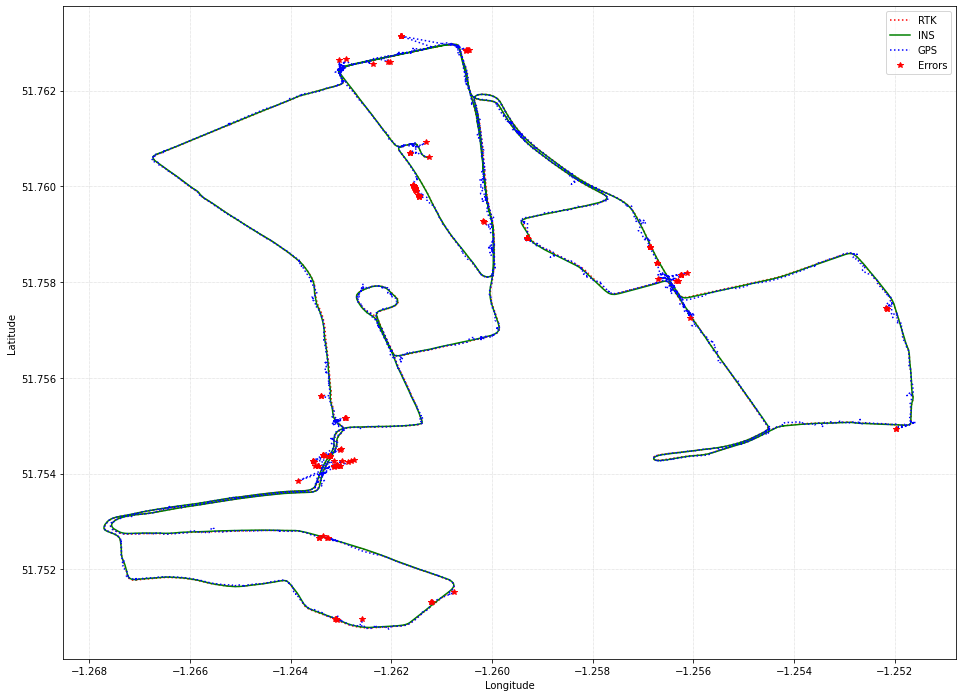

In [22]:
import numpy as np
import geopy.distance
from geopy.distance import geodesic as GD
from geopy.distance import great_circle as GRC
from math import radians, cos, sin, asin, sqrt

def geo_dist_rtk_gps(df):
    return GD(df.coord_gps, df.coord_rtk).m

def gg_dist_rtk_gps(df):
    return GRC(df.coord_gps, df.coord_rtk).m

# Form tuple column from two columns in Pandas

new_df=pd.DataFrame([])
new_df['coord_gps'] = list(zip(df3.lon_gps,df3.lat_gps))
new_df['coord_rtk'] = list(zip(df3.lon_rtk,df3.lat_rtk))
new_df['geo_dist_gps_rtk'] = new_df.apply(geo_dist_rtk_gps, axis=1)
new_df['gg_dist_gps_rtk'] = new_df.apply(gg_dist_rtk_gps, axis=1)

# new_df
for error_distance in range(20):
# for error_distance in [1,10]:
    # error_distance = 2
    new_df['labels_m'] = np.where(new_df['geo_dist_gps_rtk']>error_distance, True, False)

    other = new_df[new_df['labels_m']==True]

    print(f'With error = {error_distance} the number of occurrences is {len(other)}')

    error_locations = other.index.values.tolist()

    figure = plt.gcf()
    plt.clf()
    figure.set_size_inches(16,12)
    plt.plot(rtk['longitude'],rtk['latitude'],'r:', label='RTK')
    plt.plot(ins['longitude'],ins['latitude'],'g', label='INS')
    plt.plot(gps['longitude'],gps['latitude'],'b:', label='GPS')

    plt.plot(gps['longitude'][error_locations],gps['latitude'][error_locations],'r*', label='Errors')

    plt.plot(gps['longitude'][0],gps['latitude'][0],'r*')
    plt.grid(linestyle=':',linewidth=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    fig_name = f'Errors_geq_{error_distance}'
    plt.savefig(fig_name,dpi=200)


In [102]:
new_df['labels_m'] = np.where(new_df['geo_dist_gps_rtk']>5, True, False)

col = 'geo_dist_gps_rtk'
conditions = [new_df[col]<=1, (new_df[col]>1) & (new_df[col]<=2), (new_df[col]>2) & (new_df[col]<=3), (new_df[col]>3) & (new_df[col]<=4), (new_df[col]>4)]
# choices = ['lowest', 'low', 'high', 'highest']
choices = [int(0),int(1),int(2),int(3),int(4)] # 0:lowest, 1:low, 2:mid-high, 3:high, 4:highest
new_df['type_error'] = np.select(conditions, choices, default = np.nan)

n_lowest = len(new_df[new_df['type_error']==0])
n_low = len(new_df[new_df['type_error']==1])
n_mid_high = len(new_df[new_df['type_error']==2])
n_high = len(new_df[new_df['type_error']==3])
n_highest = len(new_df[new_df['type_error']==4])

print(f'Lowest is {n_lowest}, Low is {n_low}, Mid_high is {n_mid_high}, High is {n_high} and Highest is {n_highest}')

Lowest is 2688, Low is 3379, Mid_high is 2040, High is 1018 and Highest is 2331


In [28]:
new_df

,coord_gps,coord_rtk,geo_dist_gps_rtk,gg_dist_gps_rtk,labels_m,type_error
0,"(-1.261255, 51.760608)","(-1.2612564167, 51.7605952791)",1.424384,1.422906,False,1.0
1,"(-1.261255, 51.760608)","(-1.2612564233, 51.7605952818)",1.424165,1.422689,False,1.0
2,"(-1.261255, 51.760608)","(-1.2612564572, 51.7605952961)",1.423003,1.421534,False,1.0
3,"(-1.261255, 51.760608)","(-1.2612564467, 51.7605952917)",1.423359,1.421887,False,1.0
4,"(-1.261255, 51.760608)","(-1.2612564323, 51.7605952857)",1.423844,1.422370,False,1.0
...,...,...,...,...,...,...
11451,"(-1.261762, 51.760831)","(-1.2617618709, 51.7608346683)",0.408504,0.408051,False,0.0
11452,"(-1.261761, 51.760832)","(-1.2617618839, 51.7608346609)",0.311850,0.311708,False,0.0
11453,"(-1.26176, 51.760833)","(-1.2617618948, 51.7608346509)",0.278667,0.279417,False,0.0
11454,"(-1.26176, 51.760826)","(-1.2617618928, 51.760834673)",0.987672,0.986866,False,0.0


In [34]:
# Let us build the training data

headers = [df3.loc[:,['num_sat', 'lat_gps', 'lon_gps', 'alt_gps', 'lat_sigma', 'lon_sigma',
       'alt_sigma', 'north_gps', 'east_gps', 'down_gps', 'vel_north_ins',
       'vel_east_ins', 'vel_down_ins', 'roll_ins', 'pitch_ins', 'yaw_ins']
       ], new_df.loc[:,['geo_dist_gps_rtk','type_error']]]
training_df = pd.concat(headers, axis = 1)

regressor_df = training_df.copy()
classifier_df = training_df.copy()

regressor_df

,num_sat,lat_gps,lon_gps,alt_gps,lat_sigma,lon_sigma,alt_sigma,north_gps,east_gps,down_gps,vel_north_ins,vel_east_ins,vel_down_ins,roll_ins,pitch_ins,yaw_ins,geo_dist_gps_rtk,type_error
0,9,51.760608,-1.261255,68.932093,2.098110,1.597030,5.599122,5.735843e+06,619997.177193,-68.932093,-0.014230,-0.012981,0.001167,0.041498,0.006991,4.745905,1.424384,1.0
1,9,51.760608,-1.261255,68.927470,2.097983,1.597024,5.599248,5.735843e+06,619997.176174,-68.927470,-0.008610,-0.009942,0.001832,0.041764,0.006839,4.745868,1.424165,1.0
2,9,51.760608,-1.261255,68.921052,2.098029,1.597101,5.599438,5.735843e+06,619997.185102,-68.921052,-0.012198,-0.011781,0.000832,0.041708,0.006833,4.745866,1.423003,1.0
3,9,51.760608,-1.261255,68.921958,2.097997,1.597131,5.599644,5.735843e+06,619997.183469,-68.921958,-0.010022,-0.011145,0.001088,0.041725,0.006851,4.745879,1.423359,1.0
4,9,51.760608,-1.261255,68.927044,2.097923,1.597114,5.599744,5.735843e+06,619997.187288,-68.927044,-0.014170,-0.010856,0.002007,0.041747,0.006834,4.745871,1.423844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,10,51.760831,-1.261762,62.407233,1.872551,1.432219,3.647499,5.735867e+06,619961.590052,-62.407233,-0.029561,-0.055207,-0.007068,0.001099,-0.012628,1.258403,0.408504,0.0
11452,10,51.760832,-1.261761,62.510769,1.872550,1.432213,3.647423,5.735867e+06,619961.652986,-62.510769,-0.026230,-0.051035,-0.009839,0.001143,-0.012644,1.258469,0.311850,0.0
11453,10,51.760833,-1.261760,62.501980,1.870211,1.428933,3.642872,5.735867e+06,619961.702367,-62.501980,-0.026342,-0.053239,-0.011772,0.001042,-0.012640,1.258480,0.278667,0.0
11454,10,51.760826,-1.261760,63.597929,1.666002,1.418141,3.359005,5.735867e+06,619961.742779,-63.597929,-0.027105,-0.052281,-0.012674,0.001094,-0.012663,1.258477,0.987672,0.0


In [35]:
regressor_df.columns

Index(['num_sat', 'lat_gps', 'lon_gps', 'alt_gps', 'lat_sigma', 'lon_sigma',
       'alt_sigma', 'north_gps', 'east_gps', 'down_gps', 'vel_north_ins',
       'vel_east_ins', 'vel_down_ins', 'roll_ins', 'pitch_ins', 'yaw_ins',
       'geo_dist_gps_rtk', 'type_error'],
      dtype='object')

In [36]:
regressor_df.describe()

,num_sat,lat_gps,lon_gps,alt_gps,lat_sigma,lon_sigma,alt_sigma,north_gps,east_gps,down_gps,vel_north_ins,vel_east_ins,vel_down_ins,roll_ins,pitch_ins,yaw_ins,geo_dist_gps_rtk,type_error
count,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,1.145600e+04,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000
mean,6.009689,51.757077,-1.260927,62.184365,4.657336,4.489539,10.309064,5.735451e+06,620029.152236,-62.184365,0.010022,-0.033533,0.000802,-0.002875,-0.010301,3.672759,3.192675,1.731582
std,1.472516,0.003402,0.003870,6.064734,6.027459,7.887327,11.952628,3.800845e+02,264.874385,6.064734,3.684387,3.047823,0.077856,0.023327,0.015905,1.781775,4.941994,1.436799
min,1.000000,51.750752,-1.267708,-7.157591,0.926377,0.796497,1.544948,5.734746e+06,619572.377817,-144.130823,-7.727184,-7.970097,-0.593331,-0.063206,-0.079412,0.000270,0.010823,0.000000
25%,5.000000,51.753999,-1.263428,59.334664,2.458500,1.956968,5.575336,5.735105e+06,619863.100696,-64.457883,-2.301106,-1.475354,-0.037721,-0.019187,-0.017369,2.403602,1.047440,1.000000
50%,6.000000,51.757434,-1.261383,62.301406,3.141266,2.329378,7.681394,5.735492e+06,619997.238361,-62.301406,-0.001875,-0.009337,-0.004747,-0.007836,-0.011052,3.447656,1.867967,1.000000
75%,7.000000,51.760271,-1.258926,64.457883,5.216881,5.065054,9.744344,5.735805e+06,620159.890148,-59.334664,1.850472,1.667138,0.029735,0.010922,-0.004137,5.545831,3.315343,3.000000
max,10.000000,51.763137,-1.251586,144.130823,216.760193,163.097610,263.865601,5.736123e+06,620679.183691,7.157591,9.015801,7.644932,0.783081,0.082623,0.062891,6.282728,94.414860,4.000000


## Create numpy array from pandas dataframe to use in the Regressor

In [37]:
# Convert Pandas dataframe to numpy array to work in the algorithm

import numpy as np

# Labels are the values we want to predict, we want to predict the error in the GPS measurement
labels = np.array(regressor_df['geo_dist_gps_rtk'])

# Remove the labels from the features
# axis 1 refers to the columns

regressor_df = regressor_df.drop(['geo_dist_gps_rtk','type_error'], axis = 1)

regressor_df.head()

,num_sat,lat_gps,lon_gps,alt_gps,lat_sigma,lon_sigma,alt_sigma,north_gps,east_gps,down_gps,vel_north_ins,vel_east_ins,vel_down_ins,roll_ins,pitch_ins,yaw_ins
0,9,51.760608,-1.261255,68.932093,2.098110,1.597030,5.599122,5.735843e+06,619997.177193,-68.932093,-0.014230,-0.012981,0.001167,0.041498,0.006991,4.745905
1,9,51.760608,-1.261255,68.927470,2.097983,1.597024,5.599248,5.735843e+06,619997.176174,-68.927470,-0.008610,-0.009942,0.001832,0.041764,0.006839,4.745868
2,9,51.760608,-1.261255,68.921052,2.098029,1.597101,5.599438,5.735843e+06,619997.185102,-68.921052,-0.012198,-0.011781,0.000832,0.041708,0.006833,4.745866
3,9,51.760608,-1.261255,68.921958,2.097997,1.597131,5.599644,5.735843e+06,619997.183469,-68.921958,-0.010022,-0.011145,0.001088,0.041725,0.006851,4.745879
4,9,51.760608,-1.261255,68.927044,2.097923,1.597114,5.599744,5.735843e+06,619997.187288,-68.927044,-0.014170,-0.010856,0.002007,0.041747,0.006834,4.745871


In [41]:
# Saving feature names for later use
feature_list = list(regressor_df.columns)
# Convert to numpy array
features = np.array(regressor_df)

Split the dataset in 75% for training and 25% for testing

In [42]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [40]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (8592, 16)
Training Labels Shape: (8592,)
Testing Features Shape: (2864, 16)
Testing Labels Shape: (2864,)


# Test 1. Train a Random Forest Regressor with all the data we have

In [43]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [46]:
# Use the forest's predict method on the training data
predictions = rf.predict(train_features)
# Calculate the absolute errors
errors = abs(predictions - train_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')
mape = np.mean(100 * (errors / train_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.2 meters.
Accuracy: 86.67 %.


In [44]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.54 meters.
Accuracy: 61.11 %.


In [242]:
# Take one tree from the forest and save it as an image

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

# We get too big of a tree, not recommended

In [243]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

In [62]:
# Let us see which were the most important features for our regression

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: down_gps             Importance: 0.25
Variable: lon_sigma            Importance: 0.24
Variable: alt_gps              Importance: 0.2
Variable: lat_sigma            Importance: 0.06
Variable: lat_gps              Importance: 0.03
Variable: north_gps            Importance: 0.03
Variable: vel_north_ins        Importance: 0.03
Variable: vel_east_ins         Importance: 0.03
Variable: roll_ins             Importance: 0.03
Variable: yaw_ins              Importance: 0.03
Variable: alt_sigma            Importance: 0.02
Variable: num_sat              Importance: 0.01
Variable: lon_gps              Importance: 0.01
Variable: east_gps             Importance: 0.01
Variable: vel_down_ins         Importance: 0.01
Variable: pitch_ins            Importance: 0.01


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

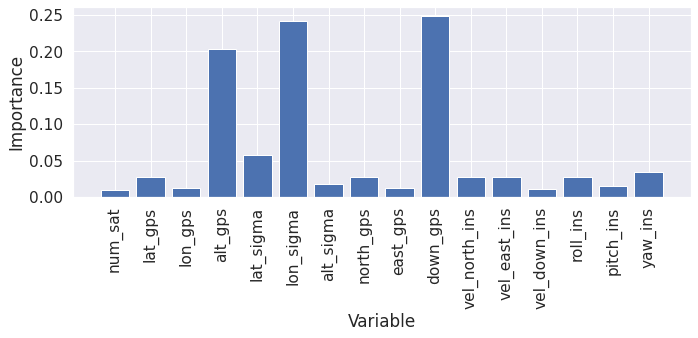

In [88]:

import matplotlib.pyplot as plt
# %matplotlib inline
# Set the style
# plt.style.use('fivethirtyeight')
figure = plt.gcf()
figure.set_size_inches(10,5)
# plt.axes().set_facecolor(color='white')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid(True)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); #plt.title('Variable Importances');
plt.tight_layout()
plt.savefig('variable_importances',dpi=600)

In [73]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the most important features
important_indices = [feature_list.index('alt_sigma'), feature_list.index('down_gps'), feature_list.index('lon_sigma'), feature_list.index('lat_sigma')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions on training set and determine the error
predictions = rf_most_important.predict(train_important)
errors = abs(predictions - train_labels)

# Display the performance metrics
print('For training set, Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / train_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')


# Make predictions on test set and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('For test set, Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

For training set, Mean Absolute Error: 0.34 meters.
Accuracy: 82.61 %.
For test set, Mean Absolute Error: 0.73 meters.
Accuracy: 51.46 %.


### Play around with some configurations of the feature space

In [72]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the most important features
important_indices = [feature_list.index('alt_gps'), feature_list.index('down_gps'), feature_list.index('lon_sigma'), feature_list.index('lat_sigma')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions on training set and determine the error
predictions = rf_most_important.predict(train_important)
errors = abs(predictions - train_labels)

# Display the performance metrics
print('For training set, Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / train_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')


# Make predictions on test set and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('For test set, Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

For training set, Mean Absolute Error: 0.36 meters.
Accuracy: 80.82 %.
For test set, Mean Absolute Error: 0.79 meters.
Accuracy: 45.49 %.


In [74]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract some important features
important_indices = [feature_list.index('lon_gps'), feature_list.index('lat_gps'), feature_list.index('lat_sigma'), feature_list.index('lon_sigma')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions on training set and determine the error
predictions = rf_most_important.predict(train_important)
errors = abs(predictions - train_labels)

# Display the performance metrics
print('For training set, Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / train_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')


# Make predictions on test set and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

For training set, Mean Absolute Error: 0.34 meters.
Accuracy: 84.33 %.
Mean Absolute Error: 0.71 meters.
Accuracy: 56.04 %.


# Test 2. Train a Random Forest Classifier with all the data we have

In [75]:
classifier_df

,num_sat,lat_gps,lon_gps,alt_gps,lat_sigma,lon_sigma,alt_sigma,north_gps,east_gps,down_gps,vel_north_ins,vel_east_ins,vel_down_ins,roll_ins,pitch_ins,yaw_ins,geo_dist_gps_rtk,type_error
0,9,51.760608,-1.261255,68.932093,2.098110,1.597030,5.599122,5.735843e+06,619997.177193,-68.932093,-0.014230,-0.012981,0.001167,0.041498,0.006991,4.745905,1.424384,1.0
1,9,51.760608,-1.261255,68.927470,2.097983,1.597024,5.599248,5.735843e+06,619997.176174,-68.927470,-0.008610,-0.009942,0.001832,0.041764,0.006839,4.745868,1.424165,1.0
2,9,51.760608,-1.261255,68.921052,2.098029,1.597101,5.599438,5.735843e+06,619997.185102,-68.921052,-0.012198,-0.011781,0.000832,0.041708,0.006833,4.745866,1.423003,1.0
3,9,51.760608,-1.261255,68.921958,2.097997,1.597131,5.599644,5.735843e+06,619997.183469,-68.921958,-0.010022,-0.011145,0.001088,0.041725,0.006851,4.745879,1.423359,1.0
4,9,51.760608,-1.261255,68.927044,2.097923,1.597114,5.599744,5.735843e+06,619997.187288,-68.927044,-0.014170,-0.010856,0.002007,0.041747,0.006834,4.745871,1.423844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,10,51.760831,-1.261762,62.407233,1.872551,1.432219,3.647499,5.735867e+06,619961.590052,-62.407233,-0.029561,-0.055207,-0.007068,0.001099,-0.012628,1.258403,0.408504,0.0
11452,10,51.760832,-1.261761,62.510769,1.872550,1.432213,3.647423,5.735867e+06,619961.652986,-62.510769,-0.026230,-0.051035,-0.009839,0.001143,-0.012644,1.258469,0.311850,0.0
11453,10,51.760833,-1.261760,62.501980,1.870211,1.428933,3.642872,5.735867e+06,619961.702367,-62.501980,-0.026342,-0.053239,-0.011772,0.001042,-0.012640,1.258480,0.278667,0.0
11454,10,51.760826,-1.261760,63.597929,1.666002,1.418141,3.359005,5.735867e+06,619961.742779,-63.597929,-0.027105,-0.052281,-0.012674,0.001094,-0.012663,1.258477,0.987672,0.0


In [ ]:
# Convert Pandas dataframe to numpy array to work in the algorithm

import numpy as np

# Labels are the values we want to predict, we want to predict the error in the GPS measurement
labels = np.array(classifier_df['type_error'])

# Remove the labels from the features
# axis 1 refers to the columns

classifier_df = classifier_df.drop(['geo_dist_gps_rtk','type_error'], axis = 1)


In [79]:
# Split the dataset in 75% and 25%

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (8592, 16)
Training Labels Shape: (8592,)
Testing Features Shape: (2864, 16)
Testing Labels Shape: (2864,)


In [80]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 100)
# Train the model on training data
rf.fit(train_features, train_labels)



RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=1000)

In [81]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predicting the Test set results
predictions = rf.predict(test_features)

accuracy_score(test_labels, predictions)
#Reverse factorize (converting y_pred from 0s,1s, 2s and 3 to lowest, low, high, highest errors
# reversefactor = dict(zip(range(4),definitions))
# y_test = np.vectorize(reversefactor.get)(y_test)
# y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# print(pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species']))

# View confusion matrix for test data and predictions
confusion_matrix(test_labels, predictions)

array([[547, 142,   6,   2,   4],
       [137, 592,  88,   3,   5],
       [ 10, 116, 325,  34,  13],
       [  0,  10,  48, 151,  43],
       [  2,   2,   8,  36, 540]])

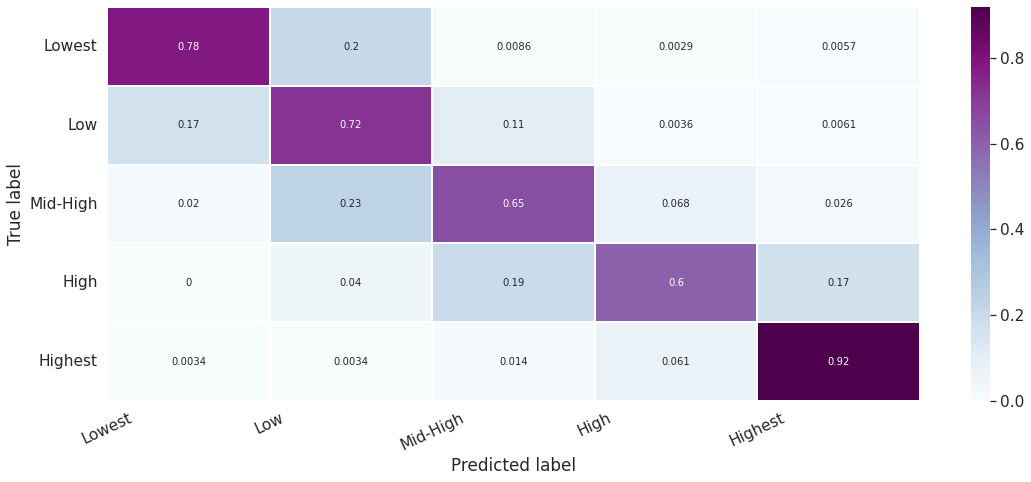

In [89]:
# Present confusion matrix
# Get and reshape confusion matrix data
import seaborn as sns

matrix = confusion_matrix(test_labels, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.BuPu, linewidths=0.2)

# Add labels to the plot
class_names = ['Lowest', 'Low', 'Mid-High', 'High', 'Highest']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model')
plt.tight_layout()
plt.savefig('confusion_matrix',dpi=400)


# RF for time series forecasting

# Time series prediction with RF

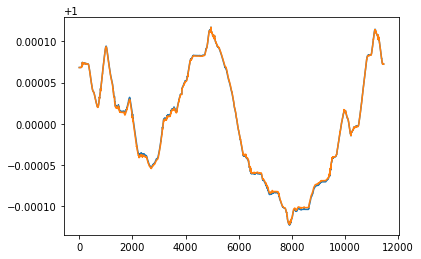

In [ ]:
#we only are gonna use the lat_gps and lon_gps data, so we extract it from the dataframe
df_new = full_df.loc[:,["lat_gps","lon_gps","north_gps","east_gps"]]
df_lat = full_df.loc[:,["lat_gps"]]
df_lon = full_df.loc[:,["lon_gps"]]
df_north = full_df.loc[:,["north_gps"]]
df_east = full_df.loc[:,["east_gps"]]

plt.plot(df_new["north_gps"]/df_new.mean(axis=0)["north_gps"])
plt.plot(df_new["lat_gps"]/df_new.mean(axis=0)["lat_gps"])
plt.show()
# type(df_new["lat_gps"])

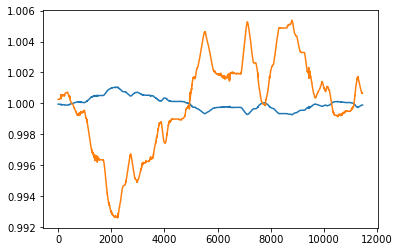

In [ ]:
plt.plot(full_df["east_gps"]/full_df.mean(axis=0)["east_gps"])
plt.plot(full_df["lon_gps"]/full_df.mean(axis=0)["lon_gps"])
plt.show()

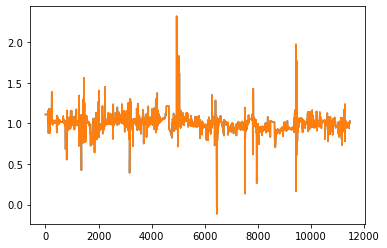

In [ ]:
plt.plot(full_df["alt_gps"]/full_df.mean(axis=0)["alt_gps"])
plt.plot(full_df["down_gps"]/full_df.mean(axis=0)["down_gps"])
plt.show()

In [ ]:

# Test how to transform time series data to a dataframe that can be used in a Supervised Learning problem
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
#define N samples for data history 
n_history = 200
values = df_lat.to_numpy()
train = series_to_supervised(values, n_in=n_history)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
trainX.shape

(11256, 200)

In [ ]:
#Prediction of lon_gps using data history
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

#define N samples for data history 
n_history = 200
# load the dataset
values = df_lat.to_numpy()
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=n_history)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000)

In [ ]:
#compare prediction of model with respect to data 
y_list = []
y_hat_list = []
for i in range(11000):
    row = values[i:i+n_history].flatten()
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    # print('Future value: %s, Predicted future value: %.6f' % (values[i+200+1], yhat[0]))
    y_list += [values[i+n_history+1]]
    y_hat_list += [yhat[0]]

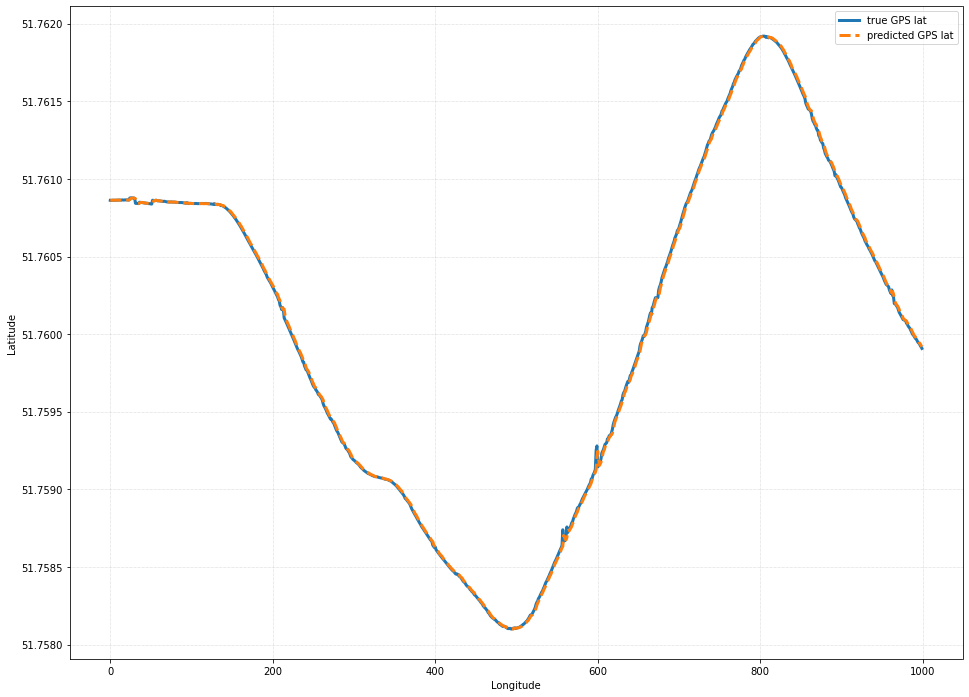

In [ ]:
figure = plt.gcf()
plt.clf()
figure.set_size_inches(16,12)

plt.plot(y_list[0:11000],label="true GPS lat",linewidth="3")
plt.plot(y_hat_list[0:11000],'--',label="predicted GPS lat",linewidth="3")

plt.grid(linestyle=':',linewidth=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
fig_name = f'prediction_GPS_lat'
plt.savefig(fig_name,dpi=200)

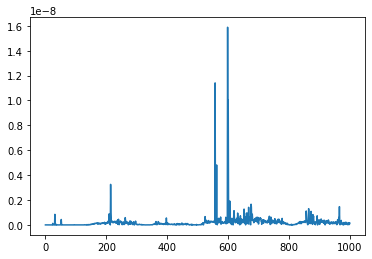

In [ ]:
error_list = []
location_errors_lat = []
for i in range(len(y_list[0:11000])):
    error_list += [(y_list[i] - y_hat_list[i])**2]
    if error_list[i] > 0.1e-8:
        location_errors_lat += [i+n_history+1]
plt.plot(error_list)
plt.show()

In [ ]:
#Prediction of lon_gps using data history
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

#define N samples for data history 
n_history = 200
# load the dataset
values = df_lon.to_numpy()
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=n_history)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model1 = RandomForestRegressor(n_estimators=1000)
model1.fit(trainX, trainy)

In [ ]:
#compare prediction of model with respect to data 
y_list1 = []
y_hat_list1 = []
for i in range(11000):
    row = values[i:i+n_history].flatten()
    # make a one-step prediction
    yhat1 = model1.predict(asarray([row]))
    # print('Future value: %s, Predicted future value: %.6f' % (values[i+200+1], yhat[0]))
    y_list1 += [values[i+n_history+1]]
    y_hat_list1 += [yhat1[0]]

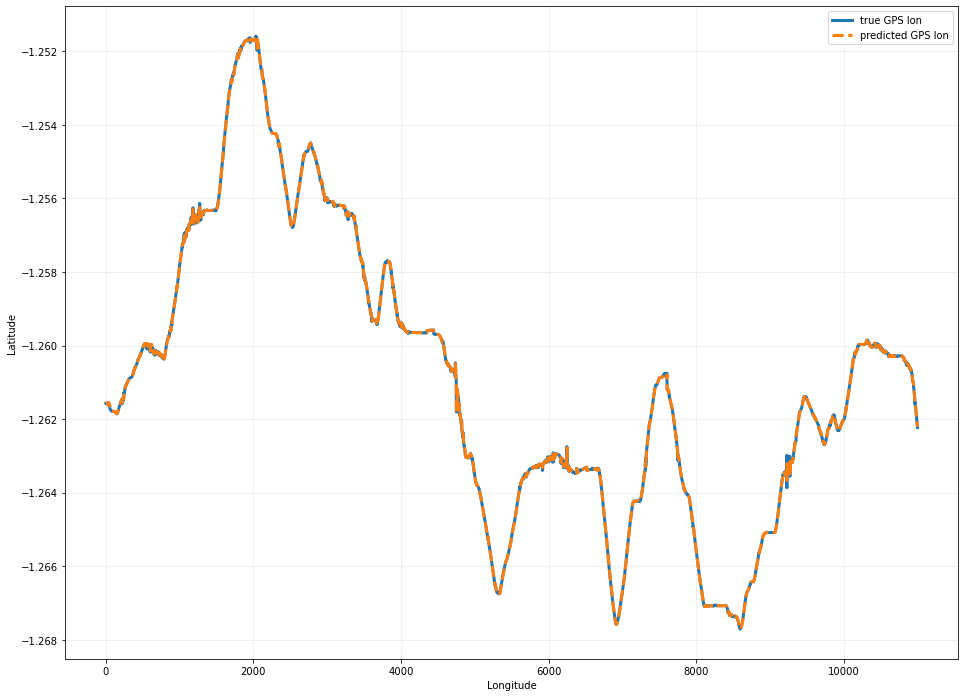

In [ ]:
figure = plt.gcf()
plt.clf()
figure.set_size_inches(16,12)

plt.plot(y_list1[0:11000],label="true GPS lon",linewidth="3")
plt.plot(y_hat_list1[0:11000],'--',label="predicted GPS lon",linewidth="3")

plt.grid(linestyle=':',linewidth=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
fig_name = f'prediction_GPS_lon'
plt.savefig(fig_name,dpi=200)

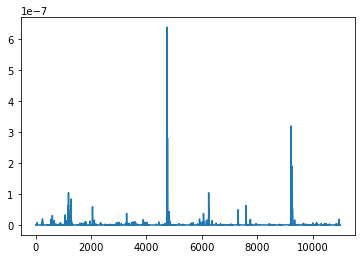

In [ ]:
error_list1 = []
location_errors_lon = []
for i in range(len(y_list1[0:11000])):
    error_list1 += [(y_list1[i] - y_hat_list1[i])**2]
    if error_list1[i] > 0.2e-8:
        location_errors_lon += [i+n_history+1]
plt.plot(error_list1)
plt.show()

In [ ]:
#Plot corrupted GPS data based on predictions
import numpy as np
import geopy.distance
from geopy.distance import geodesic as GD
from geopy.distance import great_circle as GRC
from math import radians, cos, sin, asin, sqrt

def geo_dist_rtk_gps(df):
    return GD(df.coord_gps, df.coord_rtk).m

def gg_dist_rtk_gps(df):
    return GRC(df.coord_gps, df.coord_rtk).m

# Form tuple column from two columns in Pandas

new_df=pd.DataFrame([])
new_df['coord_gps'] = list(zip(df3.lon_gps,df3.lat_gps))
new_df['coord_rtk'] = list(zip(df3.lon_rtk,df3.lat_rtk))
new_df['geo_dist_gps_rtk'] = new_df.apply(geo_dist_rtk_gps, axis=1)
new_df['gg_dist_gps_rtk'] = new_df.apply(gg_dist_rtk_gps, axis=1)

# new_df
# for error_distance in range(20):
for error_distance in [5]:
    # error_distance = 2
    new_df['labels_m'] = np.where(new_df['geo_dist_gps_rtk']>error_distance, True, False)

    other = new_df[new_df['labels_m']==True]

    print(f'With error = {error_distance} the number of occurrences is {len(other)}')

    error_locations = other.index.values.tolist()

    # print(rtk['longitude'][error_locations])

    figure = plt.gcf()
    plt.clf()
    figure.set_size_inches(16,12)
    plt.plot(rtk['longitude'],rtk['latitude'],'r:',label="RTK")
    # plt.plot(ins['longitude'],ins['latitude'],'g',label="INS")
    plt.plot(gps['longitude'],gps['latitude'],'b:',label="GPS")

    plt.plot(gps['longitude'][error_locations],gps['latitude'][error_locations],'r*',label="true error")
    plt.plot(gps['longitude'][location_errors_lat],gps['latitude'][location_errors_lat],'c*',label="pred lat GPS error")
    plt.plot(gps['longitude'][location_errors_lon],gps['latitude'][location_errors_lon],'g*',label="pred lon GPS error")

    plt.plot(gps['longitude'][0],gps['latitude'][0],'r*')
    plt.grid(linestyle=':',linewidth=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    fig_name = f'Comparison_error_lat_lon_0_2e_8m'
    plt.savefig(fig_name,dpi=200)



    figure = plt.gcf()
    plt.clf()
    figure.set_size_inches(16,12)
    plt.plot(rtk['longitude'],rtk['latitude'],'r:',label="RTK")
    # plt.plot(ins['longitude'],ins['latitude'],'g',label="INS")
    plt.plot(gps['longitude'],gps['latitude'],'b:',label="GPS")

    plt.plot(gps['longitude'][error_locations],gps['latitude'][error_locations],'r*',label="true error")
    plt.plot(gps['longitude'][location_errors_lat],gps['latitude'][location_errors_lat],'c*',label="pred lat GPS error")
    plt.plot(gps['longitude'][0],gps['latitude'][0],'r*')
    plt.grid(linestyle=':',linewidth=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    fig_name = f'Comparison_error_lat_0_2e_8m'
    plt.savefig(fig_name,dpi=200)


    figure = plt.gcf()
    plt.clf()
    figure.set_size_inches(16,12)
    plt.plot(rtk['longitude'],rtk['latitude'],'r:',label="RTK")
    # plt.plot(ins['longitude'],ins['latitude'],'g',label="INS")
    plt.plot(gps['longitude'],gps['latitude'],'b:',label="GPS")

    plt.plot(gps['longitude'][error_locations],gps['latitude'][error_locations],'r*',label="true error")
    plt.plot(gps['longitude'][location_errors_lon],gps['latitude'][location_errors_lon],'g*',label="pred lon GPS error")

    plt.plot(gps['longitude'][0],gps['latitude'][0],'r*')
    plt.grid(linestyle=':',linewidth=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    fig_name = f'Comparison_error_lon_0_2e_8m'
    plt.savefig(fig_name,dpi=200)    

# Plots that show GPS, INS and RTK localization information

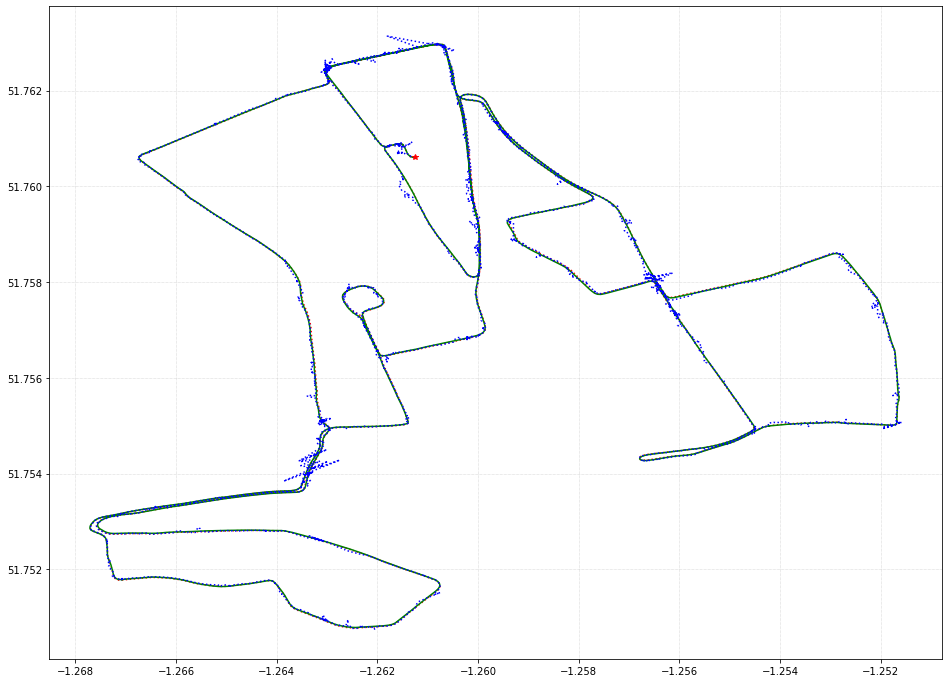

In [65]:
import matplotlib.pyplot as plt


figure = plt.gcf()
figure.set_size_inches(16,12)
plt.plot(rtk['longitude'],rtk['latitude'],'r:')
plt.plot(ins['longitude'],ins['latitude'],'g')
plt.plot(gps['longitude'],gps['latitude'],'b:')
plt.plot(gps['longitude'][0],gps['latitude'][0],'r*')
plt.grid(linestyle=':',linewidth=0.5)
plt.savefig('Latitud vs Longitude Resampled',dpi=200)

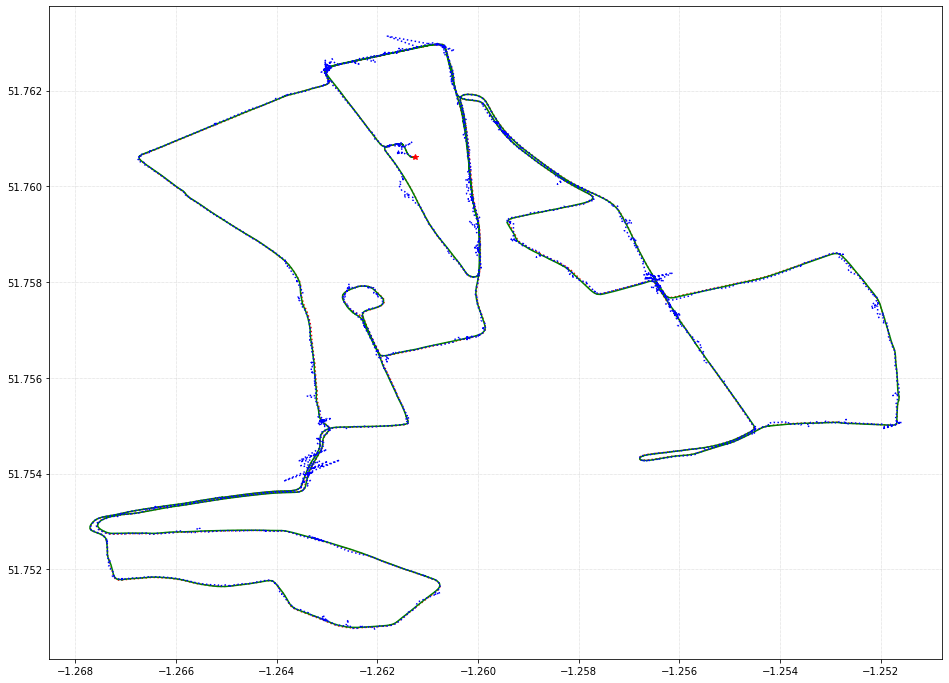

In [113]:
import matplotlib.pyplot as plt


figure = plt.gcf()
figure.set_size_inches(16,12)
plt.plot(rtk_lon,rtk_lat,'r:')
plt.plot(ins_lon,ins_lat,'g')
plt.plot(gps_lon,gps_lat,'b:')
plt.plot(gps_lon[0],gps_lat[0],'r*')
plt.grid(linestyle=':',linewidth=0.5)
plt.savefig('Latitud vs Longitude',dpi=200)


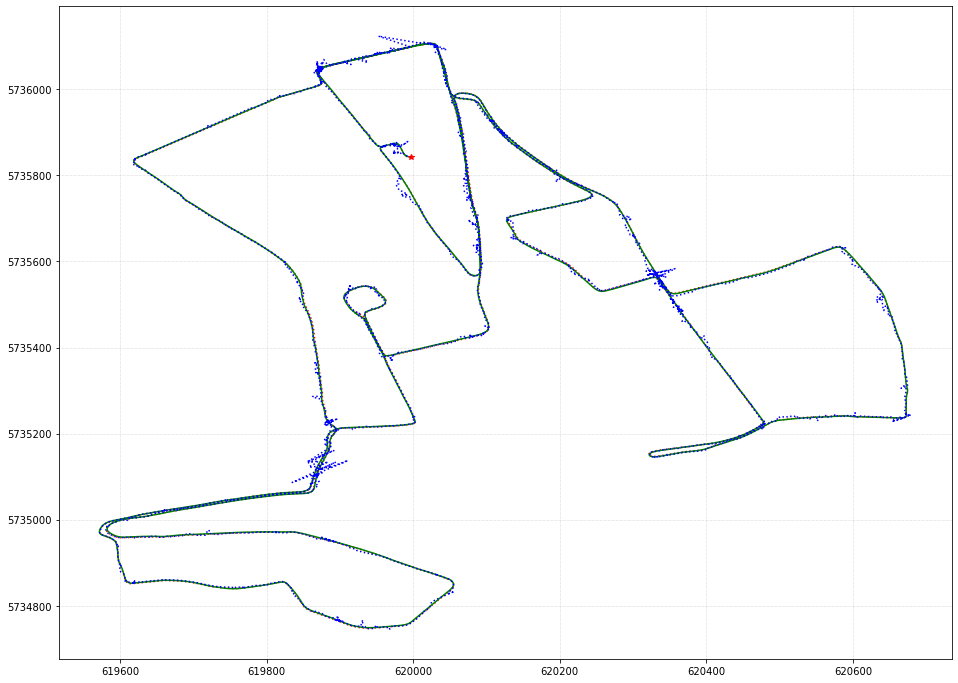

In [112]:
import matplotlib.pyplot as plt


figure = plt.gcf()
figure.set_size_inches(16,12)
plt.plot(rtk_east,rtk_north,'r:')
plt.plot(ins_east,ins_north,'g')
plt.plot(gps_east,gps_north,'b:')
plt.plot(gps_east[0],gps_north[0],'r*')
plt.grid(linestyle=':',linewidth=0.5)
plt.savefig('Northing vs Easting',dpi=200)